In [1]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import pycaret.regression as pyr


In [2]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,consumption,temperature
count,49494.000000,49494.000000
mean,3.509242,6.554019
std,3.096356,7.630308
min,0.000000,-17.299999
25%,1.263256,1.000000
50%,2.376530,6.800000
75%,5.189000,12.100000
max,18.045011,30.500000


In [3]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['time'].dt.month

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [4]:
lags = [24, 25, 26, 48, 49, 50, 72]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'avg_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().mean()
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag)
    

df.reset_index(inplace=True)

df.dropna(inplace=True)


In [5]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [6]:
last_date = df['time'].max().date()
test_start_date = last_date - timedelta(days=29)

df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

from sklearn.model_selection import train_test_split

def split_train_test_randomly(df):
    # Ensure 'time' is in datetime format
    df['time'] = pd.to_datetime(df['time']) 
    
    # Split the data randomly
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    return train_df, test_df


df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

# Apply the function to split train and test data randomly
train_0_10, test_0_10 = split_train_test_randomly(df_0_10)
train_11_24, test_11_24 = split_train_test_randomly(df_11_24)


In [7]:

excluded_features = ['time', 'temperature', 'original_location']
excluded_features_11_24 = ['time', 
                           'temperature', 
                           'original_location', 
                           'consumption_t-24h', 
                           'avg_load_t-24h',
                           'consumption_t-25h', 
                           'avg_load_t-26h',
                           'consumption_t-26h',
                           ]

pyr.setup(data=train_0_10, target='consumption', ignore_features=excluded_features, session_id=42)
best_model_0_10 = pyr.compare_models(sort='mae')
final_model_0_10 = pyr.finalize_model(best_model_0_10)

pyr.setup(data=train_11_24, target='consumption', ignore_features=excluded_features_11_24, session_id=42)
best_model_11_24 = pyr.compare_models(sort='mae')
final_model_11_24 = pyr.finalize_model(best_model_11_24)

predictions_0_10 = pyr.predict_model(final_model_0_10, data=test_0_10)
predictions_11_24 = pyr.predict_model(final_model_11_24, data=test_11_24)

combined_predictions = pd.concat([predictions_0_10, predictions_11_24]).sort_values(by='time')





,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(16112, 35)"
4,Transformed data shape,"(16112, 32)"
5,Transformed train set shape,"(11278, 32)"
6,Transformed test set shape,"(4834, 32)"
7,Ignore features,3
8,Numeric features,31
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:20:46
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0964,0.0322,0.1791,0.9965,0.0323,0.0357,0.8770
lightgbm,Light Gradient Boosting Machine,0.1432,0.0522,0.2281,0.9944,0.0463,0.0571,0.9020
rf,Random Forest Regressor,0.1299,0.0549,0.2340,0.9941,0.0422,0.0480,2.1370
dt,Decision Tree Regressor,0.1771,0.1189,0.3443,0.9872,0.0632,0.0659,0.0440
gbr,Gradient Boosting Regressor,0.2206,0.1285,0.3579,0.9862,0.0688,0.0825,0.8220
knn,K Neighbors Regressor,0.2378,0.1455,0.3809,0.9843,0.0877,0.1043,0.0280
lr,Linear Regression,0.3659,0.3282,0.5722,0.9648,0.1318,0.1685,0.4330
ada,AdaBoost Regressor,0.4759,0.3538,0.5946,0.9619,0.1821,0.2981,0.2630
br,Bayesian Ridge,0.3651,0.3764,0.6129,0.9596,0.1092,0.1376,0.0150
ridge,Ridge Regression,0.3651,0.3759,0.6124,0.9596,0.1092,0.1376,0.1650


,Description,Value
0,Session id,42
1,Target,consumption
2,Target type,Regression
3,Original data shape,"(22561, 35)"
4,Transformed data shape,"(22561, 30)"
5,Transformed train set shape,"(15792, 30)"
6,Transformed test set shape,"(6769, 30)"
7,Ignore features,8
8,Numeric features,29
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:21:55
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1028,0.0325,0.1795,0.9968,0.0321,0.0349,1.2050
lightgbm,Light Gradient Boosting Machine,0.1482,0.0534,0.2306,0.9947,0.0451,0.0526,0.8850
rf,Random Forest Regressor,0.1335,0.0544,0.2325,0.9946,0.0406,0.0447,3.2020
dt,Decision Tree Regressor,0.1775,0.1132,0.3348,0.9888,0.0586,0.0603,0.0690
knn,K Neighbors Regressor,0.2253,0.1310,0.3613,0.9871,0.0781,0.0890,0.0450
gbr,Gradient Boosting Regressor,0.2230,0.1337,0.3650,0.9868,0.0650,0.0735,1.0670
lr,Linear Regression,0.3384,0.3119,0.5576,0.9694,0.1062,0.1204,0.0300
ridge,Ridge Regression,0.3403,0.3306,0.5742,0.9675,0.0985,0.1129,0.0280
br,Bayesian Ridge,0.3403,0.3310,0.5745,0.9675,0.0985,0.1129,0.0270
ada,AdaBoost Regressor,0.4429,0.3310,0.5751,0.9673,0.1639,0.2394,0.3460


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0741,0.0170,0.1306,0.9979,0.0267,0.0293


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0799,0.0194,0.1394,0.9981,0.0263,0.0284


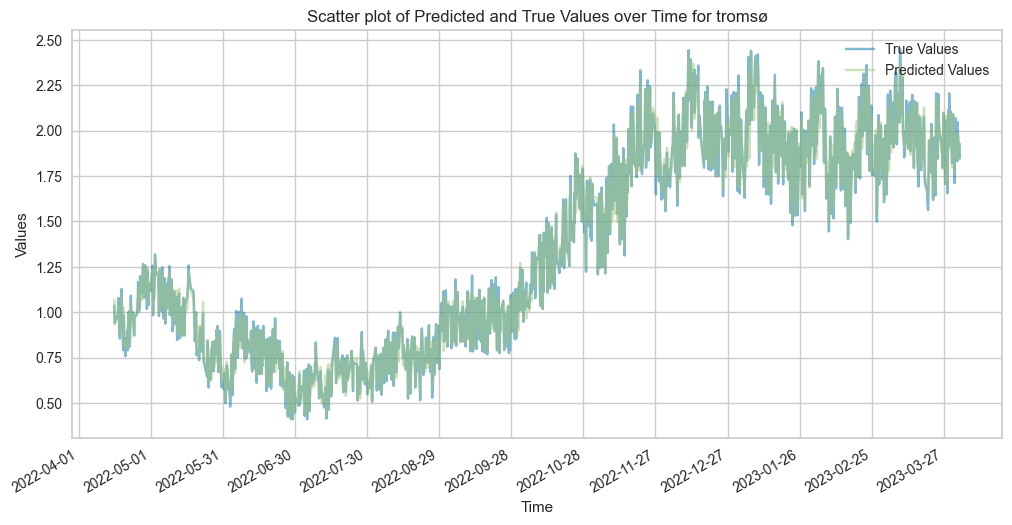

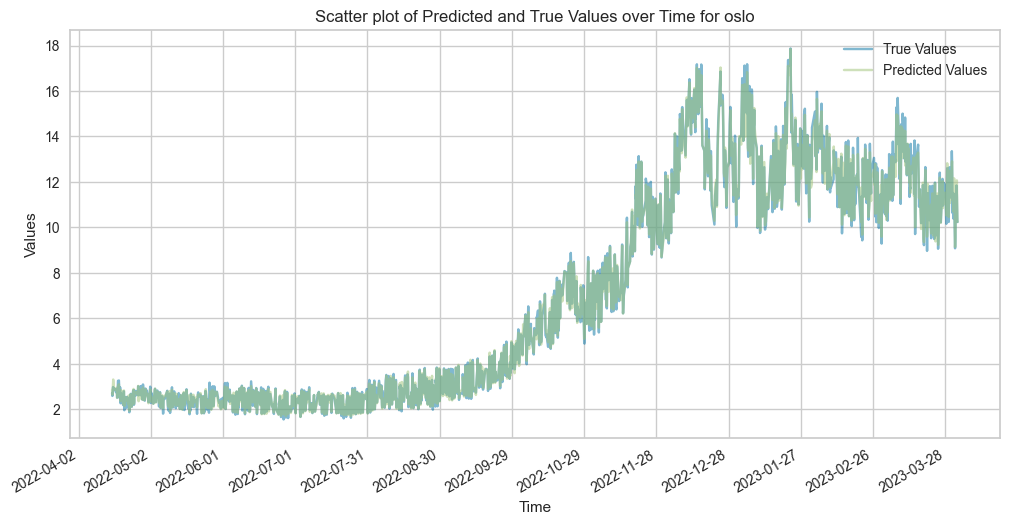

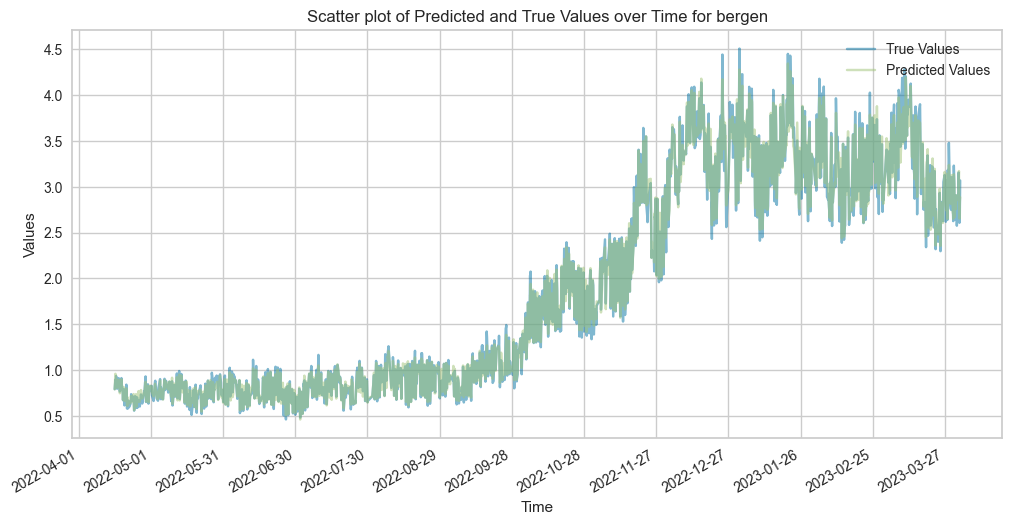

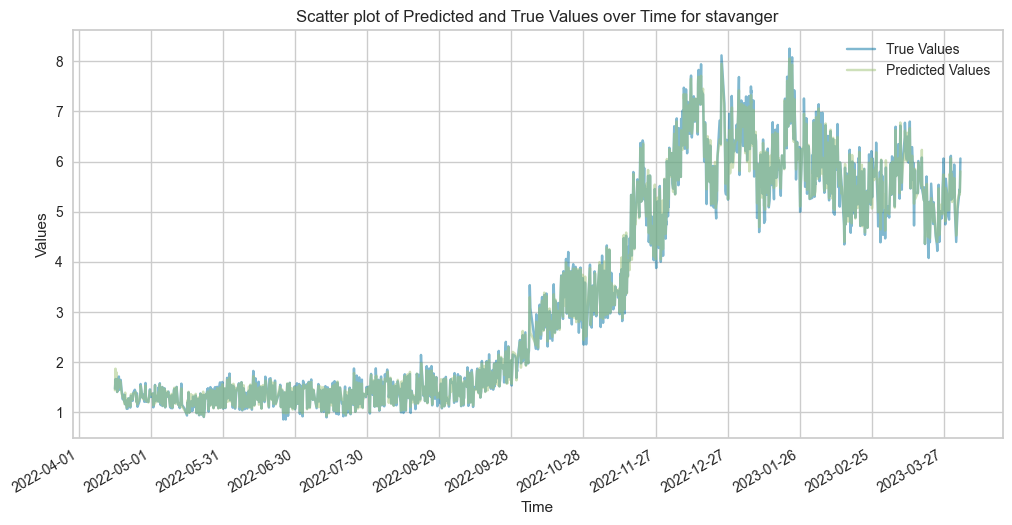

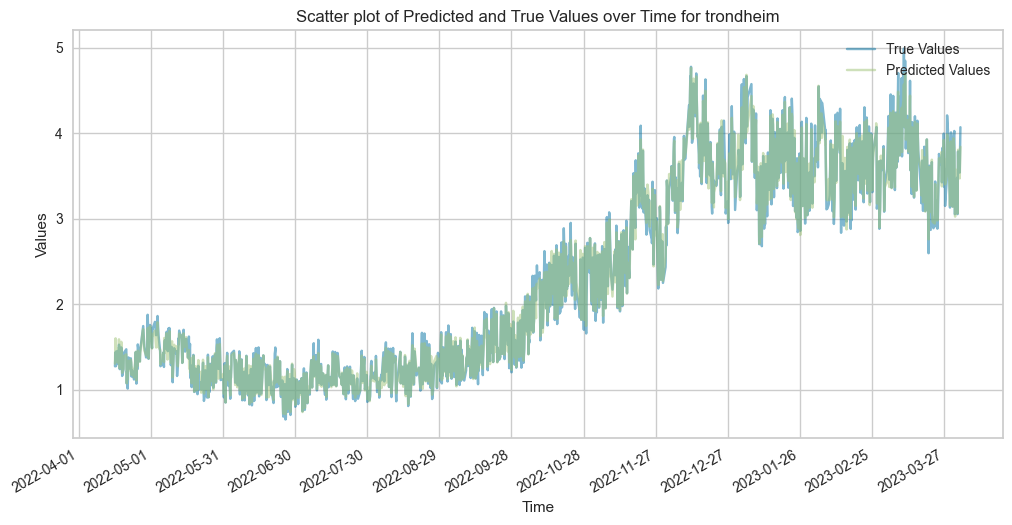

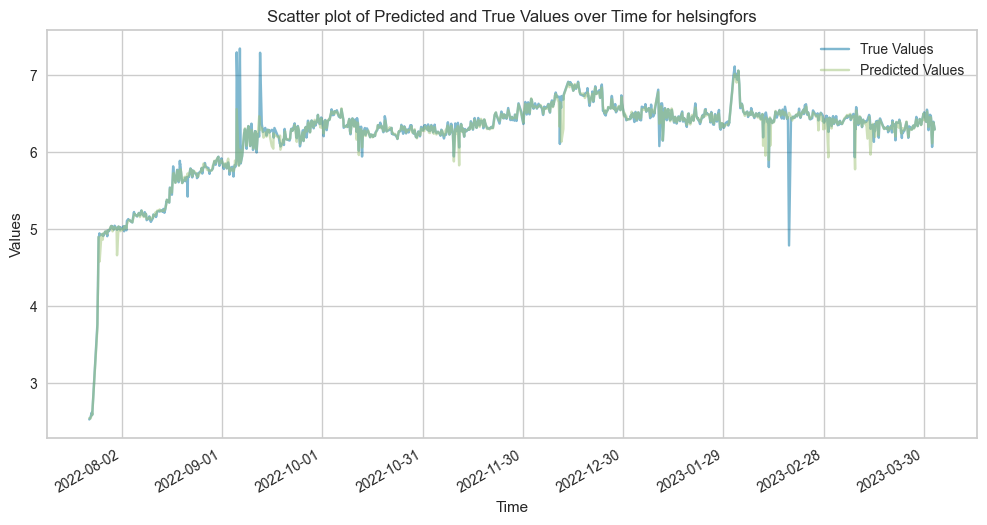

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

locations = combined_predictions['original_location'].unique()

for location in locations:
    plt.figure(figsize=(12, 6))
    
    subset_df = combined_predictions[combined_predictions['original_location'] == location]
    
    time = subset_df['time']
    true_values = subset_df['consumption']
    predicted_values = subset_df['prediction_label']
    
    plt.plot(time, true_values, alpha=0.5, label='True Values')
    plt.plot(time, predicted_values, alpha=0.5, label='Predicted Values')

    # Formatting the x-axis as date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust interval for readability if needed
    plt.gcf().autofmt_xdate()

    plt.title(f'Scatter plot of Predicted and True Values over Time for {location}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()



In [9]:
print(final_model_0_10)


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['hour', 'day_of_week',
                                             'is_weekend', 'month',
                                             'load_t-24h', 'avg_load_t-24h',
                                             'temperature_t-24h', 'load_t-25h',
                                             'avg_load_t-25h',
                                             'temperature_t-25h', 'load_t-26h',
                                             'avg_load_t-26h',
                                             'temperature_t-26h', 'load_t-48h',
                                             'avg_load_t-48h',
                                             'temperature_t-48h', 'load_t-49h',
                                             '...
                                             'location_helsingfors',
                                             'location_oslo',
                    

In [10]:
combined_predictions

,time,temperature,hour,day_of_week,is_weekend,month,load_t-24h,avg_load_t-24h,temperature_t-24h,load_t-25h,...,temperature_t-72h,original_location,location_bergen,location_helsingfors,location_oslo,location_stavanger,location_tromsø,location_trondheim,consumption,prediction_label
963,2022-04-15 21:00:00,0.3,21,4,0,4,1.081529,1.792262,1.5,1.105861,...,-1.3,tromsø,0,0,0,0,1,0,1.035823,1.067867
966,2022-04-15 22:00:00,5.5,22,4,0,4,3.394270,1.793460,2.7,3.613568,...,5.1,oslo,0,0,1,0,0,0,2.710954,2.859691
975,2022-04-16 00:00:00,2.6,0,5,1,4,0.997807,1.793022,5.8,1.016599,...,2.9,bergen,1,0,0,0,0,0,0.794924,0.793408
978,2022-04-16 00:00:00,1.6,0,5,1,4,0.973811,1.791833,1.5,1.008966,...,-2.0,tromsø,0,0,0,0,1,0,0.941246,0.932273
981,2022-04-16 01:00:00,2.7,1,5,1,4,3.154172,1.792589,2.1,3.195670,...,3.9,oslo,0,0,1,0,0,0,2.588725,2.643746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49437,2023-04-02 12:00:00,9.0,12,6,1,4,4.743316,3.502350,8.9,4.647680,...,3.5,stavanger,0,0,0,1,0,0,5.444786,5.420472
49443,2023-04-02 13:00:00,8.9,13,6,1,4,4.900423,3.502522,8.9,4.743316,...,3.7,stavanger,0,0,0,1,0,0,5.392857,5.337117
49456,2023-04-02 15:00:00,-0.1,15,6,1,4,1.846230,3.502856,-1.1,1.827624,...,-0.2,tromsø,0,0,0,0,1,0,1.846723,1.904304
49475,2023-04-02 18:00:00,3.0,18,6,1,4,3.739666,3.503575,1.0,3.509518,...,-1.8,trondheim,0,0,0,0,0,1,4.067940,3.838971
